In [1]:
import numpy as np
import sys
sys.path.insert(0, '../..') #This line adds '../..' to the path so we can import the net_framework python file
from RNN_model_GRAD import *
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
try:
    import ujson as json
except ImportError:
    import json
import scipy.linalg as slin

## Loading Trained Weights

Having trained the network weights on the remote computer, and loading the weights

In [2]:
with open('weight_history.json') as f:
    weight_history = json.load(f)

In [3]:
weight_history.keys()

dict_keys(['connectivity matrix', 'output weights', 'noise weights', 'input weights', 'trained weights', 'bias'])

Defining weights of the network. Final trained weights are in final_weights

In [4]:
noise_weights = np.array(weight_history['noise weights'])
bias_weights = np.array(weight_history['bias'])
input_weights = np.array(weight_history['input weights'])
output_weight_matrix = np.array(weight_history['output weights'])
connectivity_matrix = np.array(weight_history['connectivity matrix'])
final_weights = np.array(weight_history['trained weights'][-1])

## Defining Network

In [5]:
num_nodes = 128
time_constant = 100 #ms
timestep = 10 #ms
noise_strength = 0.01

weight_matrix = tf.Variable(final_weights)
connectivity_matrix = tf.constant(connectivity_matrix)

input_weight_matrix = tf.constant(np.vstack((bias_weights, noise_weights, input_weights)))

def rule_input(time):
    #No input for now
    return 0
    
def bias(time):
    return 1
def noise(time):
    return np.sqrt(2 * time_constant/timestep) * noise_strength * np.random.normal(0, 1)


input_funcs = [bias, noise, rule_input]

init_activations = tf.constant(np.zeros((num_nodes, 1)))
output_weight_matrix = tf.constant(output_weight_matrix)
        
network = RNN(weight_matrix, connectivity_matrix, init_activations, output_weight_matrix, time_constant = time_constant,
             timestep = timestep,activation_func = keras.activations.relu, output_nonlinearity = lambda x : x)

## Simulating Network Output Without Input

100%|██████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 1312.85it/s]


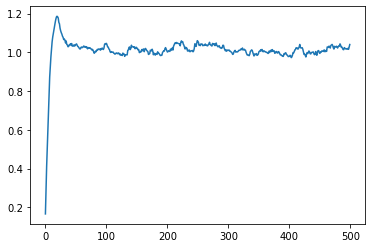

In [6]:
time = 5000 #ms
inputs = network.convert(time, input_funcs)
outputs, activations = network.simulate(time, inputs, input_weight_matrix)

outputs = tf.transpose(outputs).numpy()[0]
fig, ax = plt.subplots()
plt.plot(range(len(outputs)), outputs)
plt.show()

## Testing Network

Now, simulating network activity to ensure that it works.

In [7]:
network.reset_activations()
def rule_input(time):
    #running for 5 seconds = 5000ms
    if time < 2500:
        return .2 + np.random.normal(0, .05)
    else:
        return .8 + np.random.normal(0, .05)
def target_func(time):
    #running for 5 seconds = 5000ms
    #Reverse of rule_input
    if time < 2500:
        return .8
    else:
        return .2

input_funcs[2] = rule_input
inputs = network.convert(time, input_funcs)

outputs, activations = network.simulate(time, inputs, input_weight_matrix)

100%|██████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 1300.33it/s]


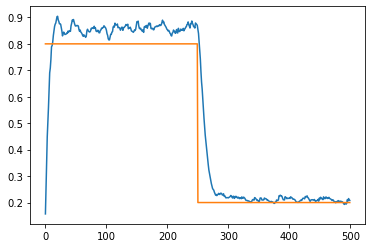

In [8]:

outputs = tf.transpose(outputs).numpy()[0]

fig, ax = plt.subplots()
plt.plot(range(len(outputs)), outputs)
plt.plot(range(len(outputs)), [target_func(t * timestep) for t in range(len(outputs))])
plt.show()

In [9]:
activations = np.asarray(activations)

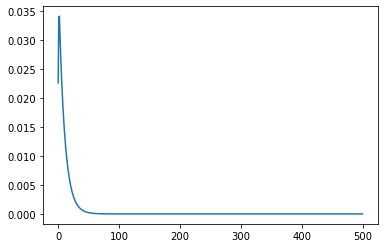

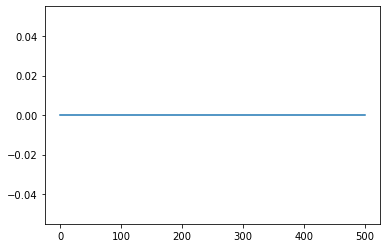

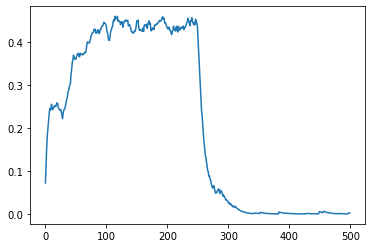

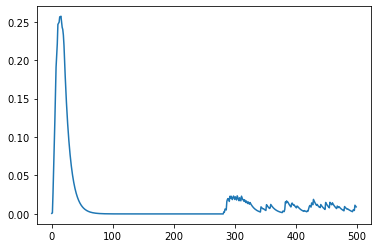

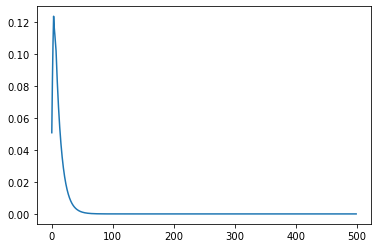

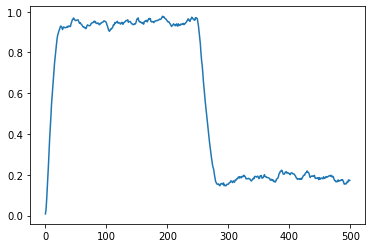

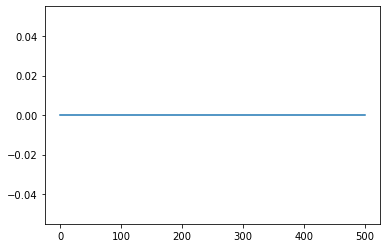

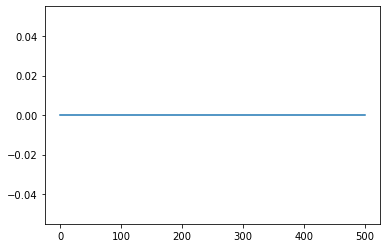

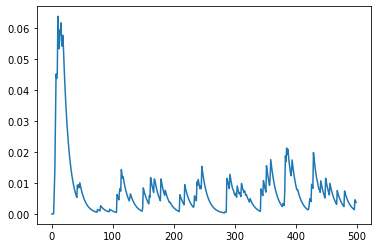

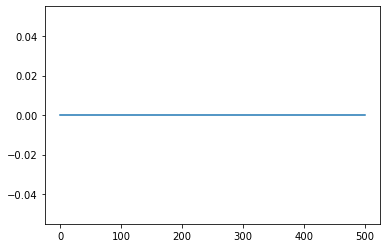

In [10]:
for i in range(10):
    fig, ax = plt.subplots()
    plt.plot(range(len(activations[:,i])), activations[:,i])
    plt.show()

In [11]:
net_weight_history = weight_history['trained weights']

In [12]:
print(len(net_weight_history))

50


## Principal Values of Weight Matrix

Plotting change in singular values over training iteration

In [13]:
num_singular_values = 25
values = []
variance_prop = []
for mat in tqdm(net_weight_history):
    u, s, vh = np.linalg.svd(mat)
    values.append(s[:num_singular_values])
    tot_variance = np.dot(s,s)
    variance_prop.append([val**2/tot_variance for val in s])

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 72.96it/s]


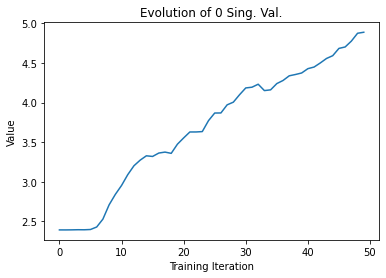

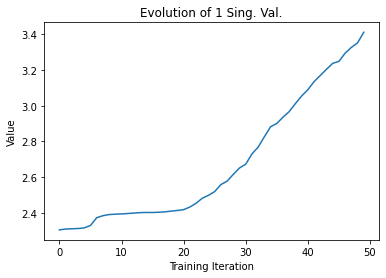

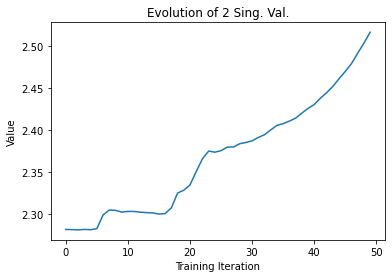

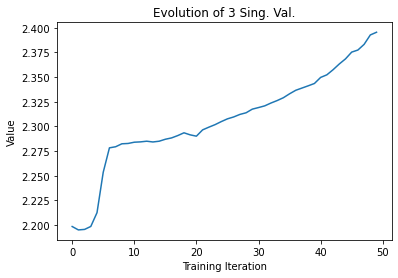

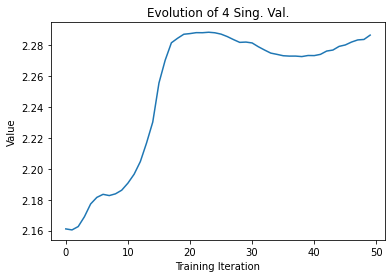

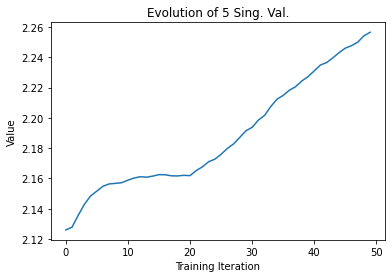

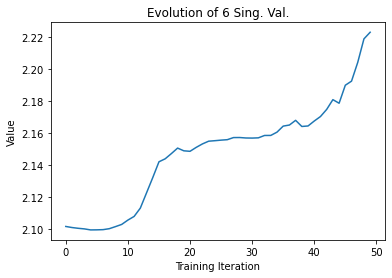

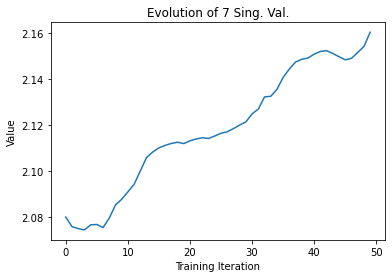

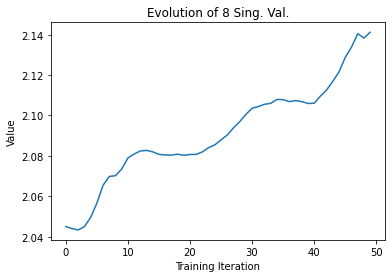

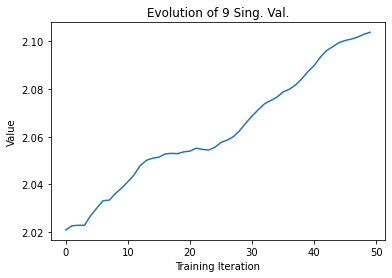

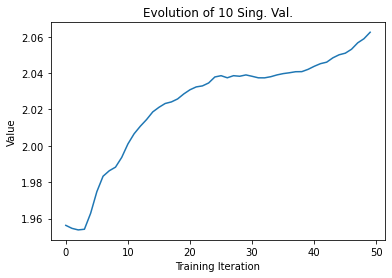

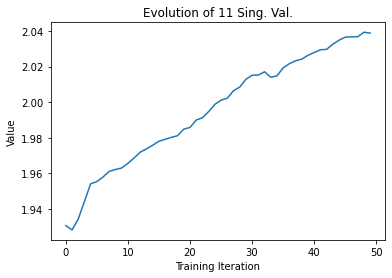

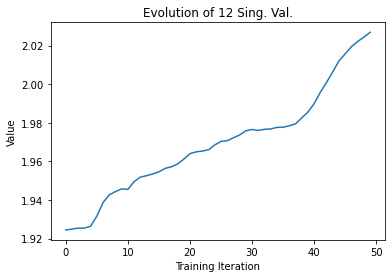

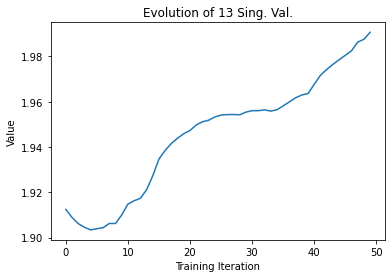

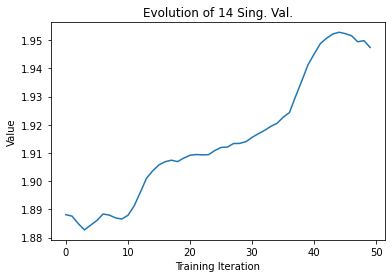

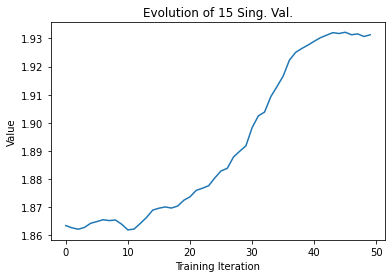

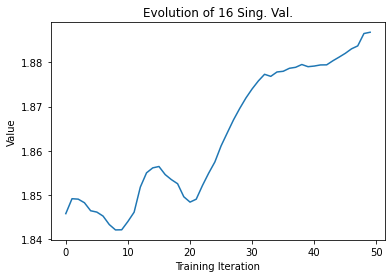

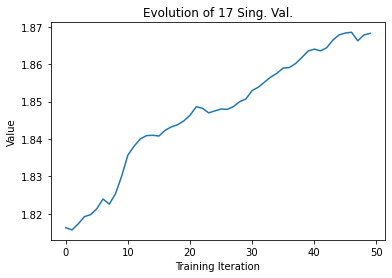

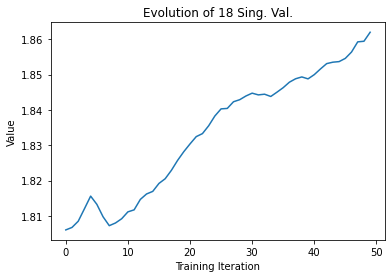

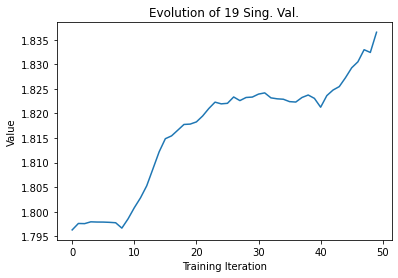

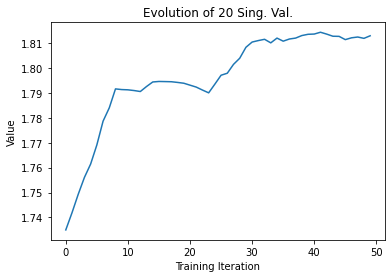

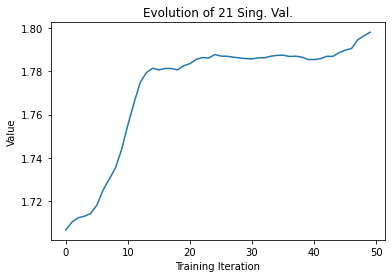

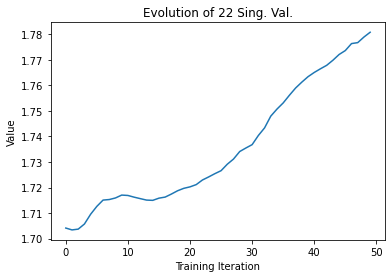

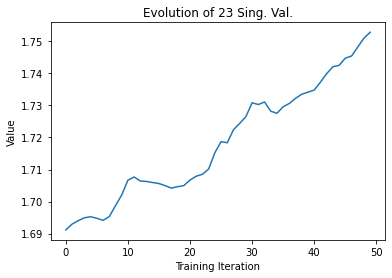

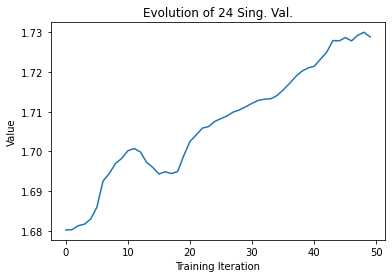

In [14]:
#The i'th column is the evolution of the i'th singular value
values = np.asarray(values)
num_total_iters = values[:, 0].shape[0]

for i in range(num_singular_values):
    fig, ax = plt.subplots()
    plt.plot(range(num_total_iters), values[:, i])
    plt.title('Evolution of ' + str(i) + ' Sing. Val.')
    plt.xlabel('Training Iteration')
    plt.ylabel('Value')
    plt.show()


Plotting percent variance captured in singular values over training iteration

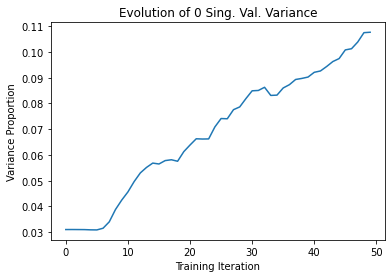

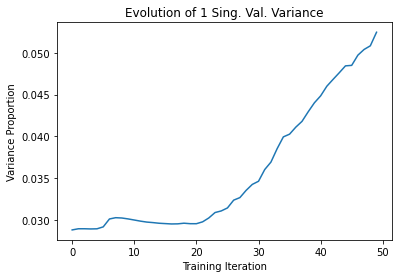

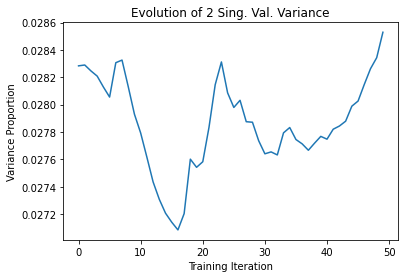

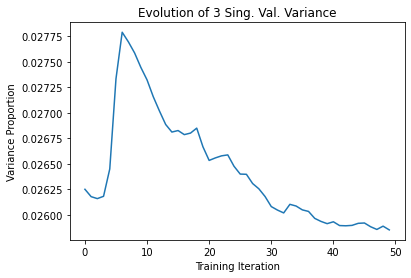

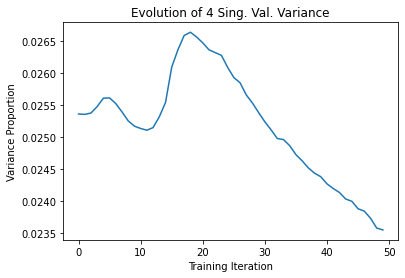

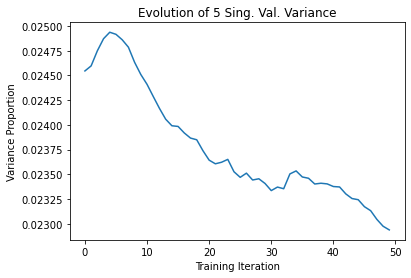

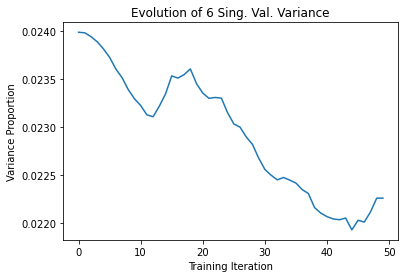

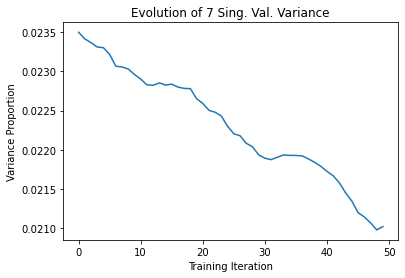

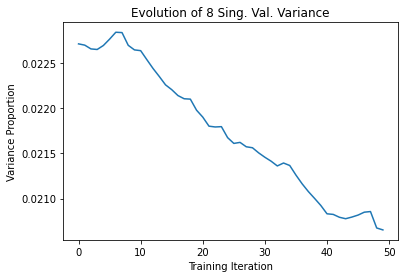

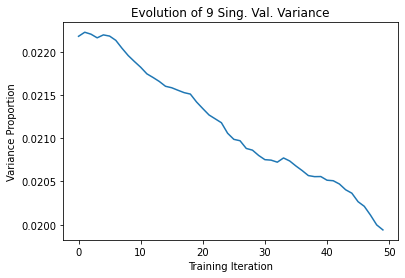

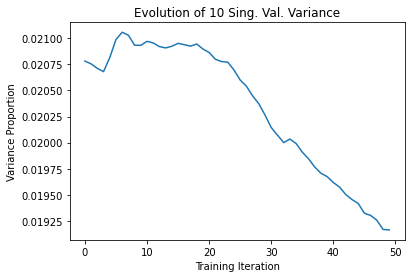

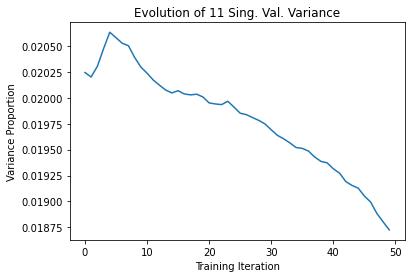

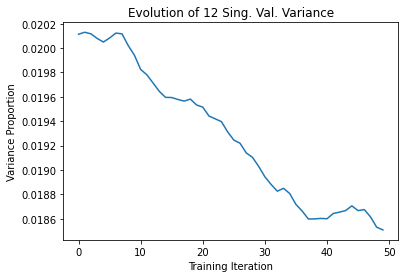

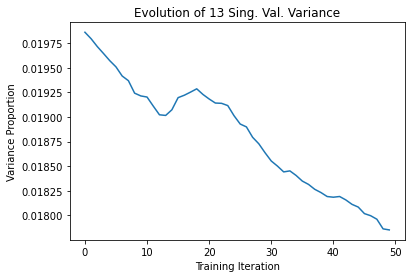

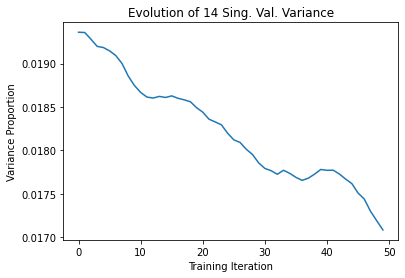

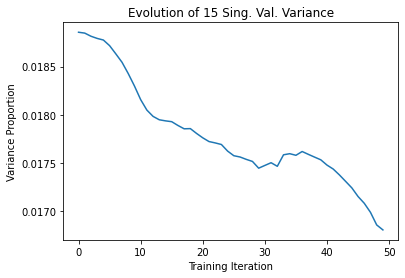

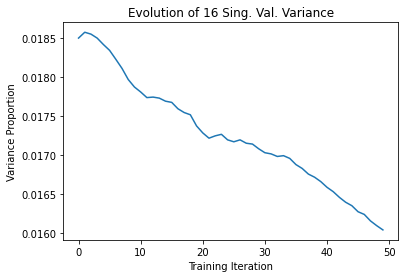

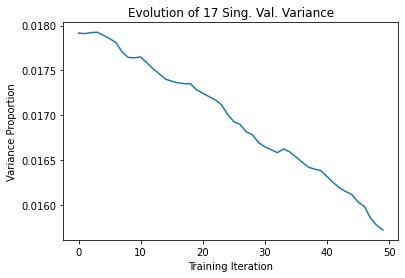

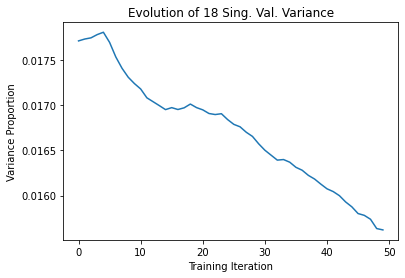

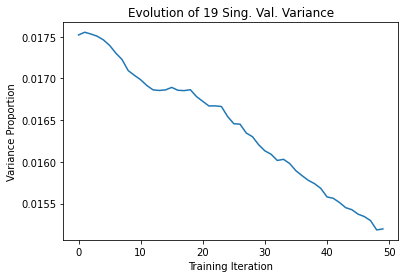

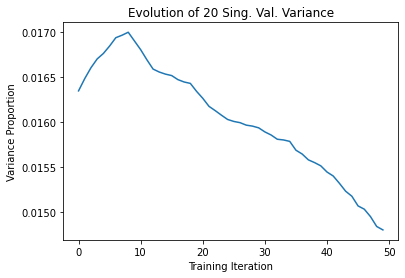

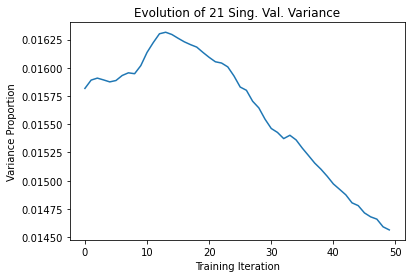

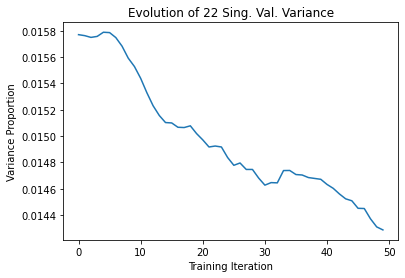

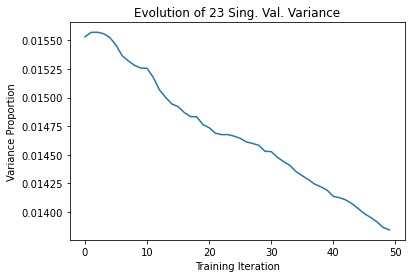

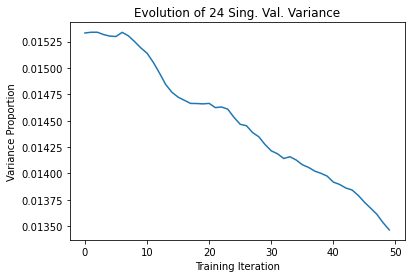

In [15]:
variance_prop = np.asarray(variance_prop)
for i in range(num_singular_values):
    fig, ax = plt.subplots()
    plt.plot(range(num_total_iters), variance_prop[:, i])
    plt.title('Evolution of ' + str(i) + ' Sing. Val. Variance')
    plt.xlabel('Training Iteration')
    plt.ylabel('Variance Proportion')
    plt.show()

## Schur Decomp.

Plotting sum of squares of off-diagonal components in schur decomposition of the matrices over training iteration

In [16]:
values = []
for mat in tqdm(net_weight_history):
    T, Z = slin.schur(mat)
    values.append(np.linalg.norm(T))
values = np.asarray(values)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 75.62it/s]


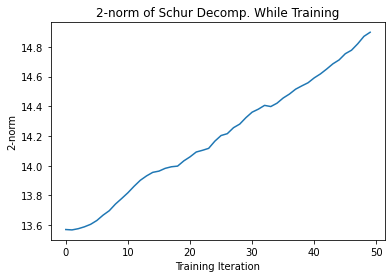

In [17]:
fig, ax = plt.subplots()
plt.plot(range(num_total_iters), values)
plt.xlabel('Training Iteration')
plt.ylabel('2-norm')
plt.title('2-norm of Schur Decomp. While Training')
plt.show()

## Looking at Weight Matrix

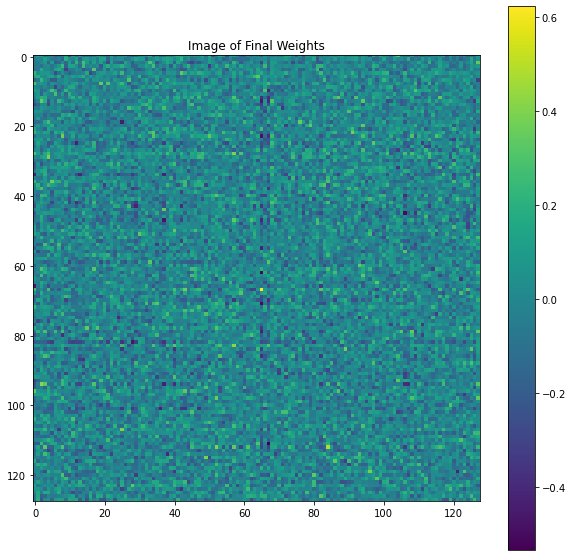

In [18]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
plt.imshow(final_weights)
plt.title('Image of Final Weights')
plt.colorbar()

In [19]:
np.mean(final_weights)

-0.0037102959805259406

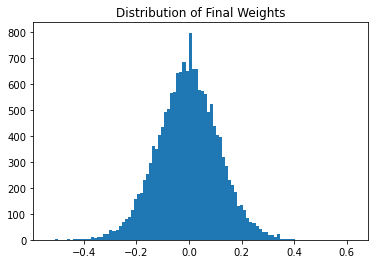

In [20]:
flattened = final_weights.flatten()
plt.hist(flattened, bins = 100)
plt.title('Distribution of Final Weights')
plt.show()

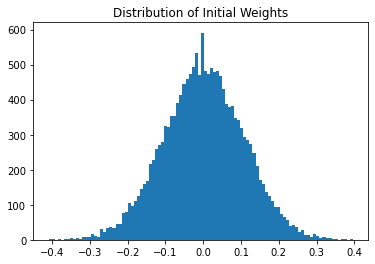

In [21]:
init = np.array(weight_history['trained weights'][0])
flattened = init.flatten()
plt.hist(flattened, bins = 100)
plt.title('Distribution of Initial Weights')
plt.show()

## Eigenvalues

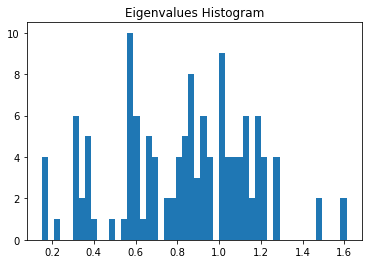

In [22]:
eig = np.linalg.eigvals(final_weights)
plt.hist(np.abs(eig), bins = 50)
plt.title('Eigenvalues Histogram')
plt.show()

## White Noise Input

In [23]:
#White noise input

time = 10000
network.reset_activations()
def rule_input(time):
    #running for 5 seconds = 5000ms
    return np.random.normal(0, 1)

input_funcs[2] = rule_input
inputs = network.convert(time, input_funcs)
outputs, activations = network.simulate(time, inputs, input_weight_matrix)


outputs = tf.transpose(outputs).numpy()[0]

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1271.91it/s]


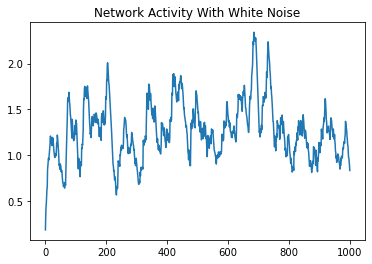

In [24]:
fig, ax = plt.subplots()
plt.plot(range(len(outputs)), outputs)
plt.title('Network Activity With White Noise')
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['mat', 'time', 'eig', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Populating the interactive namespace from numpy and matplotlib


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:854: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = f_indices.astype(np.intp)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\transforms.py:1966: ComplexWarning: Casting complex values to real discards the imaginary part
  x, y = float(x), float(y)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # This is added back by

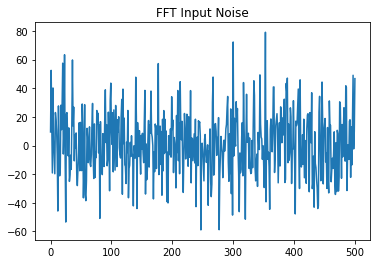

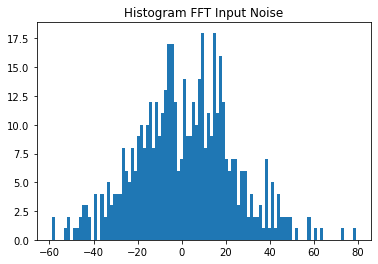

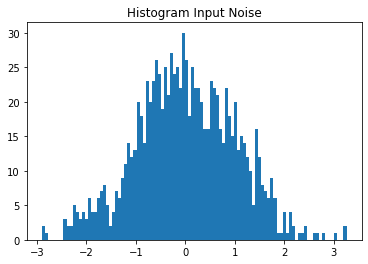

In [25]:
#Frequency space for Gaussian Noise
%pylab inline
fig1, ax1 = plt.subplots(1,1)
plt.plot(range(int(len(inputs[:, 2])/2) + 1), np.fft.rfft(inputs[:, 2]))
plt.title('FFT Input Noise')
fig1.show()

fig2, ax2 = plt.subplots(1,1)
plt.hist(np.fft.rfft(inputs[:, 2]), bins = 100)
plt.title('Histogram FFT Input Noise')
fig2.show()

fig3, ax3 = plt.subplots(1,1)
plt.hist(np.asarray(inputs[:, 2]), bins = 100)
plt.title('Histogram Input Noise')
fig2.show()

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


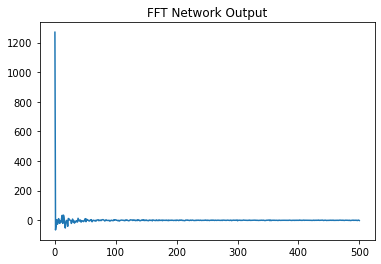

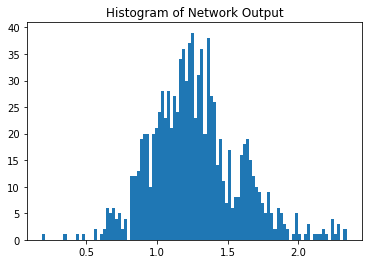

In [26]:
plt.plot(range(int(len(outputs)/2) + 1), np.fft.rfft(outputs))
plt.title('FFT Network Output')
plt.show()


plt.hist(outputs, bins = 100)
plt.title('Histogram of Network Output')
plt.show()

## Looking at Stationary Activity With Inputs Between 0, 1

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1337.85it/s]


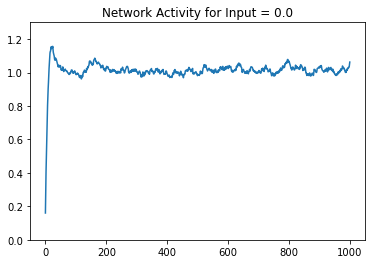

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1336.93it/s]


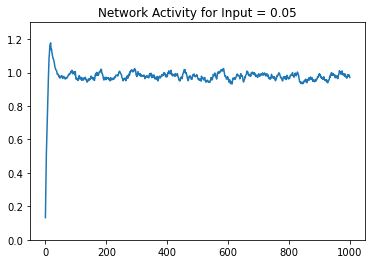

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1337.70it/s]


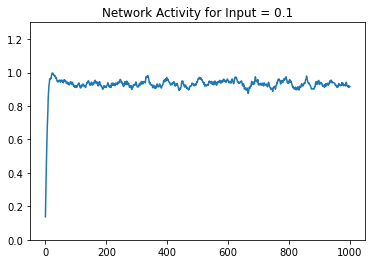

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1301.63it/s]


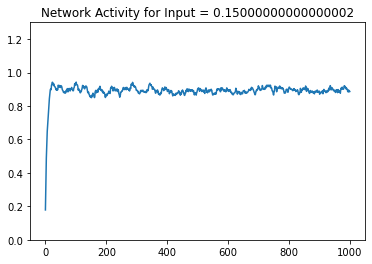

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1405.00it/s]


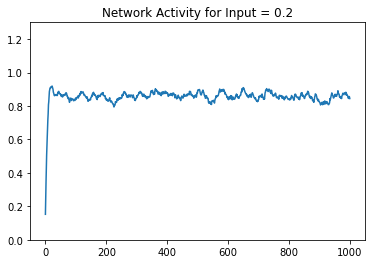

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1369.74it/s]


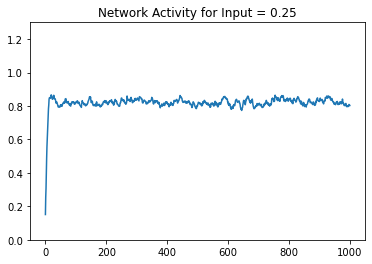

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1488.70it/s]


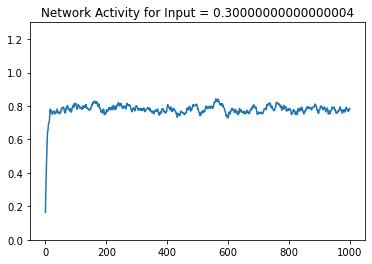

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1251.77it/s]


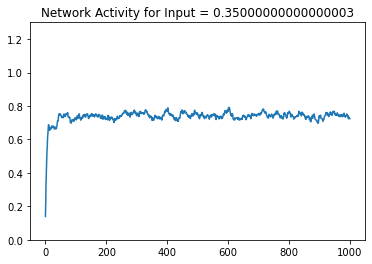

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1539.07it/s]


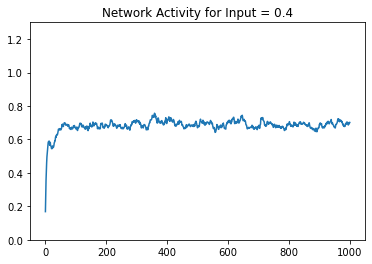

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1369.78it/s]


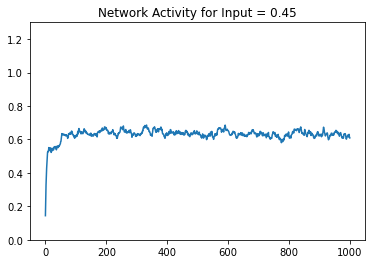

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1483.04it/s]


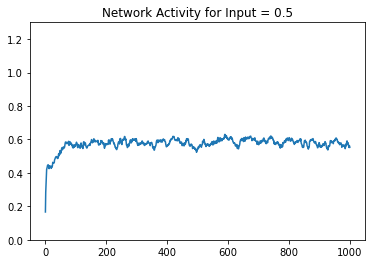

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1524.87it/s]


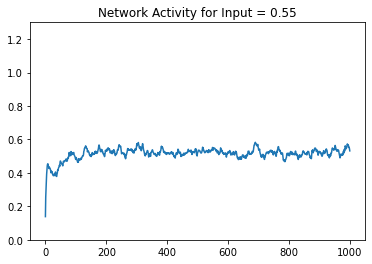

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1563.78it/s]


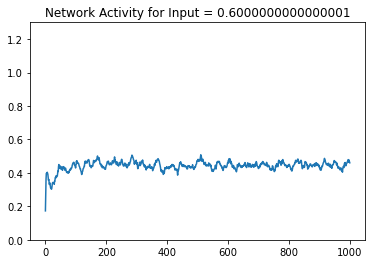

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1523.95it/s]


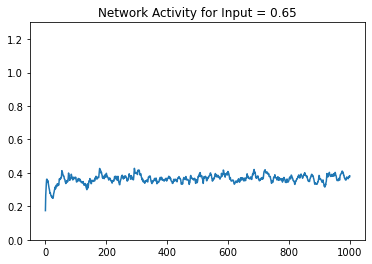

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1588.27it/s]


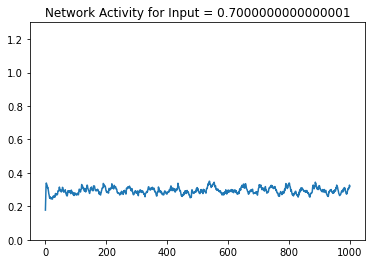

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1556.95it/s]


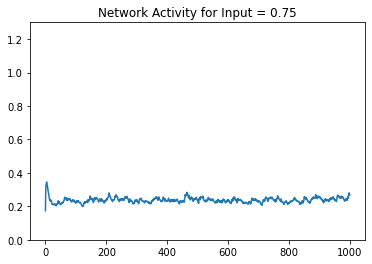

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1581.01it/s]


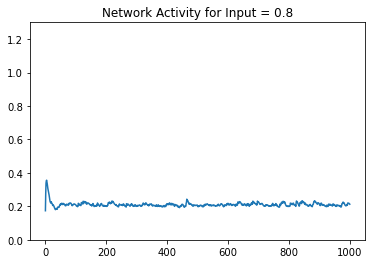

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1551.95it/s]


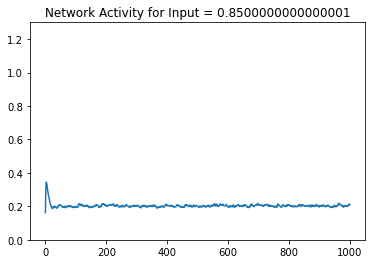

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1526.29it/s]


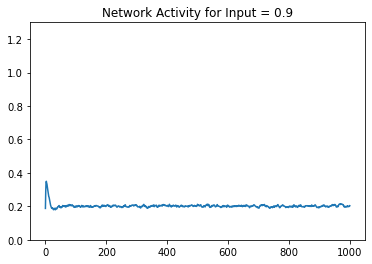

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1533.82it/s]


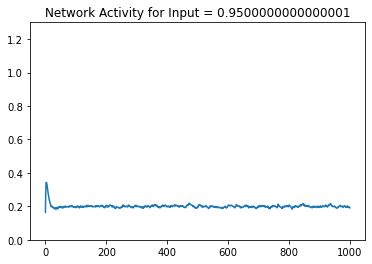

In [27]:
#Input is in range 0, 1
for n in range(20):
    time = 10000
    inp = n * 0.05
    network.reset_activations()
    def rule_input(time):
        #running for 5 seconds = 5000ms
        return inp + np.random.normal(0, 0.05)

    input_funcs[2] = rule_input
    inputs = network.convert(time, input_funcs)
    outputs, activations = network.simulate(time, inputs, input_weight_matrix)

    outputs = tf.transpose(outputs).numpy()[0]
    
    fig, ax = plt.subplots()
    plt.plot(range(len(outputs)), outputs)
    plt.title('Network Activity for Input = ' + str(inp))
    plt.ylim(0, 1.3)
    plt.show()

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1475.00it/s]


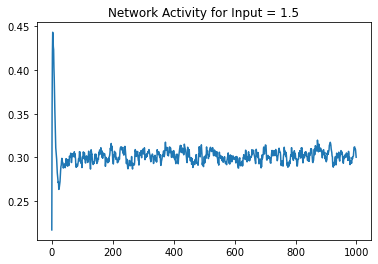

In [28]:
#Trying High input - Activity begins to increase again.
time = 10000
inp = 1.5
network.reset_activations()
def rule_input(time):
    #running for 5 seconds = 5000ms
    return inp + np.random.normal(0, 0.05)

input_funcs[2] = rule_input
inputs = network.convert(time, input_funcs)
outputs, activations = network.simulate(time, inputs, input_weight_matrix)

outputs = tf.transpose(outputs).numpy()[0]

fig, ax = plt.subplots()
plt.plot(range(len(outputs)), outputs)
plt.title('Network Activity for Input = ' + str(inp))
plt.show()

Plotting average activity value for different inputs

In [29]:
#Input is in range 0, 1
averages = []
inputs_arr = []
for n in tqdm(np.arange(-10, 40)):
    time = 10000
    inp = n * 0.05
    inputs_arr.append(inp)
    network.reset_activations()
    def rule_input(time):
        #running for 5 seconds = 5000ms
        return inp + np.random.normal(0, 0.05)

    input_funcs[2] = rule_input
    inputs = network.convert(time, input_funcs)
    outputs, activations = network.simulate(time, inputs, input_weight_matrix, disable_progress_bar = True)

    outputs = tf.transpose(outputs).numpy()[0]
    avg = np.mean(outputs)
    averages.append(avg)


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:33<00:00,  1.50it/s]


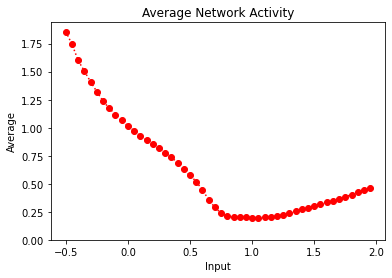

In [30]:
fig, ax = plt.subplots(1,1)
plt.plot(inputs_arr, averages, 'ro:')
plt.title('Average Network Activity')
plt.ylabel('Average')
plt.xlabel('Input')
plt.ylim(0)
plt.show()

## DCA Trajectories

This part requires installation of Dynamical Components Analysis from the BouchardLab GitHub

In [146]:
from dca.dca import DynamicalComponentsAnalysis as DCA
from sklearn.linear_model import Ridge as RR
from sklearn.metrics import r2_score
from scipy.linalg import subspace_angles

1. Defining X matrix using dynamics of each node in the network (each row is a different timestep)
2. Then running DCA on this network activity to get a low-dimensional subspace.
3. Then fitting data to output using linear regression (no intercept) - plot r^2 score for fit.

In [34]:
time = 15000

network.reset_activations()
def rule_input(time):
    #running for 15 seconds = 15000ms
    if time < 5000:
        return .2 + np.random.normal(0, .05)
    elif time >= 5000 and time < 10000:
        return .8 + np.random.normal(0, .05)
    else:
        return .2 + np.random.normal(0, .05)
def target_func(time):
    #Reverse of rule_input
    #running for 15 seconds = 15000ms
    if time < 5000:
        return .8
    elif time >= 5000 and time < 10000:
        return .2
    else:
        return .8

input_funcs[2] = rule_input
inputs = network.convert(time, input_funcs)

outputs, activations = network.simulate(time, inputs, input_weight_matrix)

100%|████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:01<00:00, 1359.18it/s]


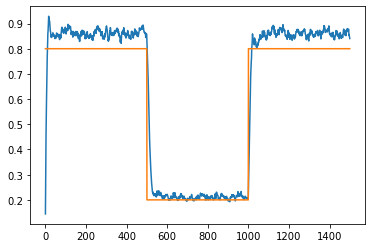

In [35]:
outputs = tf.transpose(outputs).numpy()[0]

fig, ax = plt.subplots()
plt.plot(range(len(outputs)), outputs)
plt.plot(range(len(outputs)), [target_func(t * timestep) for t in range(len(outputs))])
plt.show()

In [36]:
activations = np.asarray(activations)

Running DCA on inputs

In [119]:
max_dim = 10
ds = np.arange(1, max_dim+1)

In [120]:
X = activations
Y = np.reshape(outputs, (outputs.size, 1))

In [140]:
pi = np.zeros(ds.size) #Predictive Information
dca_scores = np.zeros(ds.size)
dca_model = DCA(T=10, d=128)
dca_model.estimate_data_statistics(X) # only need to estimate this once
max_pi = dca_model.score() # PI of data with no dimensionality reduction

rr_model = RR(alpha=1e-6)
rr_model.fit(X, Y)
max_score = r2_score(Y, rr_model.predict(X))

In [161]:
subspaces = []
for ii, d in enumerate(ds):
    print(d)
    dca_model.fit_projection(d=d)
    pi[ii] = dca_model.score()
    Xd = dca_model.transform(X)
    subspaces.append(Xd)
    rr_model = RR(alpha=1e-6)
    rr_model.fit(Xd, Y)
    dca_scores[ii] = r2_score(Y, rr_model.predict(Xd))

1
2
3
4
5
6
7
8
9
10


Text(0, 0.5, '0-1 normalized metric')

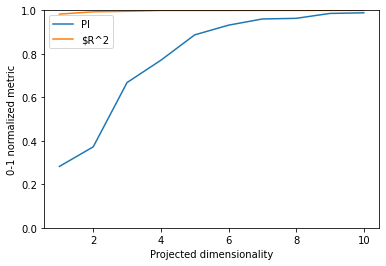

In [142]:
plt.plot(ds, np.asarray(pi)/max_pi.numpy(), label='PI')
plt.plot(ds, dca_scores/max_score, label=r'$R^2')
plt.ylim(0, 1)
plt.legend(loc='best')
plt.xlabel('Projected dimensionality')
plt.ylabel('0-1 normalized metric')

Plotting prediction from a one-dimensional projection of neural activity

Text(0.5, 1.0, 'Fitting 1D projection to Output')

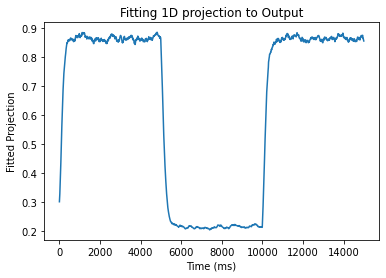

In [143]:
d = 1
dca_model.fit_projection(d=d)
pi[ii] = dca_model.score()
Xd = dca_model.transform(X)
rr_model = RR(alpha=1e-6)
rr_model.fit(Xd, Y)
plt.plot(np.arange(0, time, 10), rr_model.predict(Xd))
plt.xlabel('Time (ms)')
plt.ylabel('Fitted Projection')
plt.title('Fitting 1D projection to Output')

In [152]:
#Plots of 5D subspaces
d = 5
dca_model.fit_projection(d=d)
pi[ii] = dca_model.score()
Xd = dca_model.transform(X)

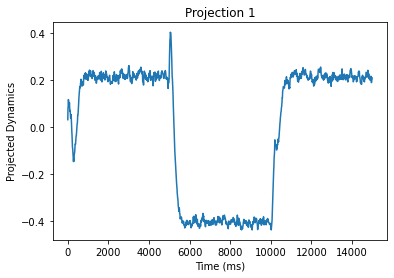

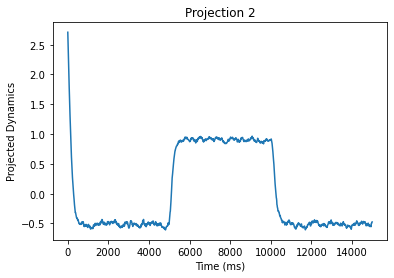

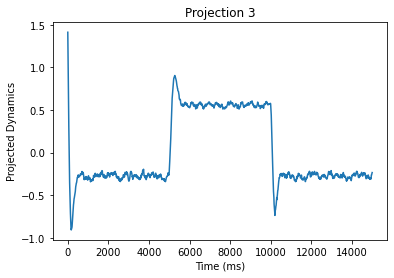

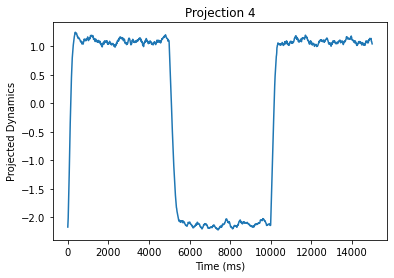

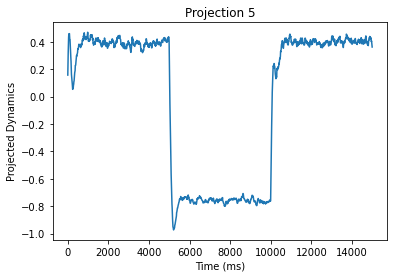

In [153]:
for i in range(d):
    plt.plot(np.arange(0, time, 10),Xd.T[i])
    plt.title('Projection ' + str(i + 1))
    plt.xlabel('Time (ms)')
    plt.ylabel('Projected Dynamics')
    plt.show()

In [156]:
dca_model.fit_projection(d=d)
pi[ii] = dca_model.score()
Xd = dca_model.transform(X)
rr_model = RR(alpha=1e-6)
rr_model.fit(Xd, Y)


Ridge(alpha=1e-06)

Text(0.5, 1.0, 'Fitting 5D projection to Output')

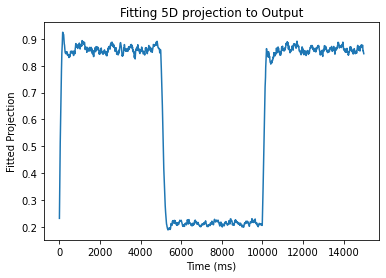

In [157]:
plt.plot(np.arange(0, time, 10), rr_model.predict(Xd))
plt.xlabel('Time (ms)')
plt.ylabel('Fitted Projection')
plt.title('Fitting 5D projection to Output')

Subspace angles for each projection (1D - 10D)

Plotting scatter of all subspace angles for each pair

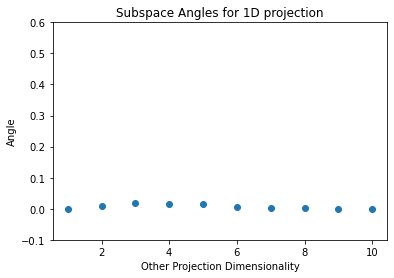

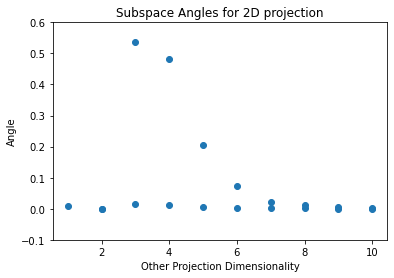

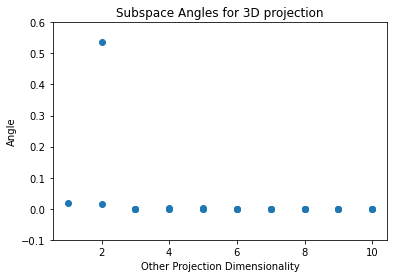

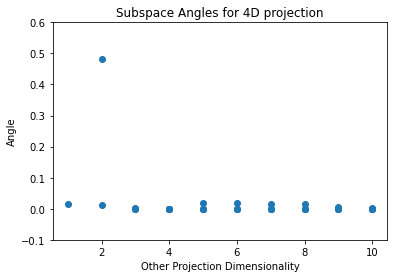

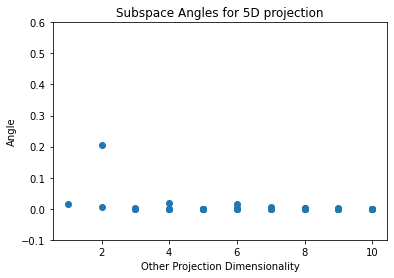

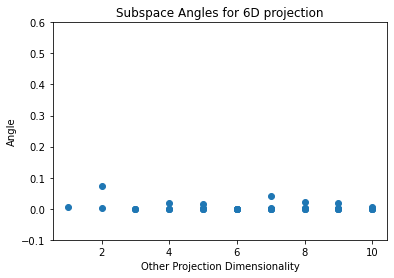

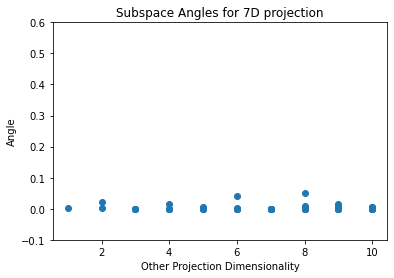

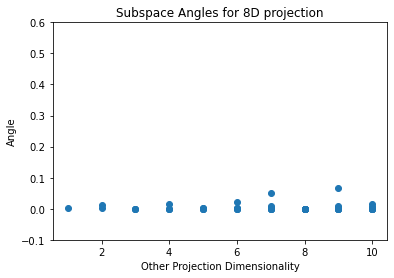

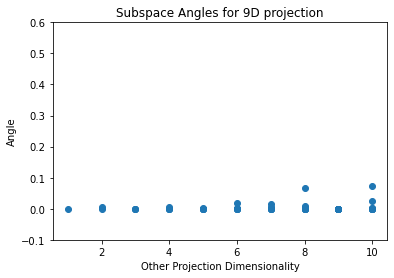

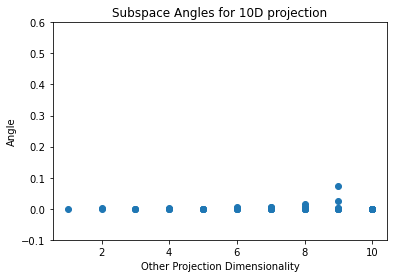

In [166]:
for d in ds:
    x = []
    y = []
    for tmpDim in ds:
        angls = subspace_angles(subspaces[d-1], subspaces[tmpDim - 1])
        x = np.append(x, tmpDim * np.ones(angls.size))
        y = np.append(y, angls)
    fig, ax = plt.subplots(1,1)
    ax.set_title('Subspace Angles for ' + str(d) + 'D projection')
    ax.set_xlabel('Other Projection Dimensionality')
    ax.set_ylabel('Angle')
    ax.scatter(x, y)
    plt.ylim(-0.1, 0.6)
    plt.show()

Subspace angles tend to be fairly low with a few outliers. 

### Running DCA on the different attractors and comparing